# Getting Started
 - Shows collision detection
 - Provides a plotting function
 - Creates a slightly optimized submission

In [1]:
import shapely
print(f'Using shapely {shapely.__version__}')

Using shapely 2.1.2


In [2]:
import math
import os
import random
from decimal import Decimal, getcontext

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
from shapely import affinity, touches
from shapely.geometry import Polygon
from shapely.ops import unary_union
from shapely.strtree import STRtree
import time

pd.set_option('display.float_format', '{:.12f}'.format)

# Set precision for Decimal
getcontext().prec = 25
scale_factor = Decimal('1e15')

In [3]:
GRID_STEP_X = Decimal(0.7)
GRID_STEP_Y = Decimal(1.0)

ROW_HEIGHT_UNIT = Decimal('1') 
TREE_WIDTH_UNIT = Decimal('1')
SCALE_FACTOR = Decimal('1e15')

getcontext().prec = 25

In [4]:
# Build the index of the submission, in the format:
#  <trees_in_problem>_<tree_index>

index = [f'{n:03d}_{t}' for n in range(1, 201) for t in range(n)]

In [5]:
class ChristmasTree:
    """Represents a single, rotatable Christmas tree of a fixed size."""

    def __init__(self, center_x='0', center_y='0', angle='0', placement_id = 0):
        """Initializes the Christmas tree with a specific position and rotation."""
        self.center_x = Decimal(center_x)
        self.center_y = Decimal(center_y)
        self.angle = Decimal(angle)
        self.placement_id = placement_id

        trunk_w = Decimal('0.15')
        trunk_h = Decimal('0.2')
        base_w = Decimal('0.7')
        mid_w = Decimal('0.4')
        top_w = Decimal('0.25')
        tip_y = Decimal('0.8')
        tier_1_y = Decimal('0.5')
        tier_2_y = Decimal('0.25')
        base_y = Decimal('0.0')
        trunk_bottom_y = -trunk_h

        initial_polygon = Polygon(
            [
                # Start at Tip
                (Decimal('0.0') * scale_factor, tip_y * scale_factor),
                # Right side - Top Tier
                (top_w / Decimal('2') * scale_factor, tier_1_y * scale_factor),
                (top_w / Decimal('4') * scale_factor, tier_1_y * scale_factor),
                # Right side - Middle Tier
                (mid_w / Decimal('2') * scale_factor, tier_2_y * scale_factor),
                (mid_w / Decimal('4') * scale_factor, tier_2_y * scale_factor),
                # Right side - Bottom Tier
                (base_w / Decimal('2') * scale_factor, base_y * scale_factor),
                # Right Trunk
                (trunk_w / Decimal('2') * scale_factor, base_y * scale_factor),
                (trunk_w / Decimal('2') * scale_factor, trunk_bottom_y * scale_factor),
                # Left Trunk
                (-(trunk_w / Decimal('2')) * scale_factor, trunk_bottom_y * scale_factor),
                (-(trunk_w / Decimal('2')) * scale_factor, base_y * scale_factor),
                # Left side - Bottom Tier
                (-(base_w / Decimal('2')) * scale_factor, base_y * scale_factor),
                # Left side - Middle Tier
                (-(mid_w / Decimal('4')) * scale_factor, tier_2_y * scale_factor),
                (-(mid_w / Decimal('2')) * scale_factor, tier_2_y * scale_factor),
                # Left side - Top Tier
                (-(top_w / Decimal('4')) * scale_factor, tier_1_y * scale_factor),
                (-(top_w / Decimal('2')) * scale_factor, tier_1_y * scale_factor),
            ]
        )
        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(rotated,
                                          xoff=float(self.center_x * scale_factor),
                                          yoff=float(self.center_y * scale_factor))

In [6]:
def generate_weighted_angle():
    """
    Generates a random angle with a distribution weighted by abs(sin(2*angle)).
    This helps place more trees in corners, and makes the packing less round.
    """
    while True:
        angle = random.uniform(0, 2 * math.pi)
        if random.uniform(0, 1) < abs(math.sin(2 * angle)):
            return angle

In [7]:
def improve_angle(tree, placed_trees, initial_side, iterations=12, start_step=15):
    """
    Local search angle optimizer.
    - tree: the newly placed tree to optimize
    - placed_trees: all other trees already placed
    - initial_side: the current bounding square side length
    """

    best_angle = float(tree.angle)
    best_side = float(initial_side)

    step = start_step

    for _ in range(iterations):
        improved = False

        for direction in [+1, -1]:
            try_angle = best_angle + direction * step

            # Rotation candidate
            rotated_poly = affinity.rotate(
                tree.polygon,
                direction * step,
                origin=(
                    float(tree.center_x * scale_factor),
                    float(tree.center_y * scale_factor),
                )
            )

            # Test collision with all other trees
            collision = False
            for other in placed_trees:
                if other is tree:
                    continue
                if rotated_poly.intersects(other.polygon) and not rotated_poly.touches(other.polygon):
                    collision = True
                    break

            if collision:
                continue

            # Temporarily update for loss evaluation
            tmp_polygons = [t.polygon if t is not tree else rotated_poly for t in placed_trees]
            union_bounds = unary_union(tmp_polygons).bounds

            minx = Decimal(union_bounds[0]) / scale_factor
            miny = Decimal(union_bounds[1]) / scale_factor
            maxx = Decimal(union_bounds[2]) / scale_factor
            maxy = Decimal(union_bounds[3]) / scale_factor

            width = maxx - minx
            height = maxy - miny
            side = max(width, height)

            # Compare s^2 / n  → but n is constant → compare just side
            if float(side) < best_side:
                best_side = float(side)
                best_angle = try_angle
                tree.polygon = rotated_poly
                tree.angle = Decimal(str(best_angle))
                improved = True

        if not improved:
            step /= 2  # reduce search radius

    return tree

In [8]:
def improve_tree_local(tree, placed_trees, initial_side, iterations=12, pos_step=0.5, angle_step=15):
    """
    Local search optimizer for both position (x, y) and angle of a tree.
    
    Changes made:
    1. Cached float conversions of Decimal values to avoid repeated float(tree.center_x) calls.
    2. Reduced redundant float(scale_factor) multiplication; stored as `sf`.
    3. Rotate first around current candidate position instead of original center.
    4. Minor loop clean-up: avoid unnecessary candidate creation if collision.
    """
    # Convert once to float
    center_x_f = float(tree.center_x)
    center_y_f = float(tree.center_y)
    sf = float(scale_factor)

    best_x = center_x_f
    best_y = center_y_f
    best_angle = float(tree.angle)
    best_side = float(initial_side)

    for _ in range(iterations):
        improved = False

        # Try movements in x, y
        for dx, dy in [(pos_step, 0), (-pos_step, 0), (0, pos_step), (0, -pos_step), (0,0)]:
            # Try rotations
            for d_angle in [angle_step, -angle_step, 0]:
                try_x = best_x + dx
                try_y = best_y + dy
                try_angle = best_angle + d_angle

                # Rotate around **current candidate position**
                rotated_poly = affinity.rotate(
                    tree.polygon,
                    d_angle,
                    origin=(try_x * sf, try_y * sf)
                )

                # Translate to candidate position
                candidate_poly = affinity.translate(
                    rotated_poly,
                    xoff=(try_x - center_x_f) * sf,
                    yoff=(try_y - center_y_f) * sf
                )

                # Collision check
                collision = any(
                    candidate_poly.intersects(other.polygon) and not candidate_poly.touches(other.polygon)
                    for other in placed_trees if other is not tree
                )
                if collision:
                    continue

                # Evaluate bounding square
                tmp_polys = [t.polygon if t is not tree else candidate_poly for t in placed_trees]
                union_bounds = unary_union(tmp_polys).bounds

                minx = Decimal(union_bounds[0]) / scale_factor
                miny = Decimal(union_bounds[1]) / scale_factor
                maxx = Decimal(union_bounds[2]) / scale_factor
                maxy = Decimal(union_bounds[3]) / scale_factor

                side = max(maxx - minx, maxy - miny)

                # Accept improvement
                if float(side) < best_side:
                    best_side = float(side)
                    best_x = try_x
                    best_y = try_y
                    best_angle = try_angle
                    tree.polygon = candidate_poly
                    tree.center_x = Decimal(str(best_x))
                    tree.center_y = Decimal(str(best_y))
                    tree.angle = Decimal(str(best_angle))
                    improved = True

        if not improved:
            pos_step /= 2
            angle_step /= 2  # reduce step sizes if no improvement

    return tree


In [9]:
def improve_tree_derivative(tree, placed_trees, initial_side,
                            iterations=20, alpha_pos=0.1, alpha_angle=0.05,
                            max_move=5.0, max_rot=45.0):
    """
    Derivative-based local optimizer for a single tree:
    - tree: the tree to optimize
    - placed_trees: all other trees already placed
    - initial_side: current bounding square side length
    - iterations: number of optimization iterations
    - alpha_pos: step size multiplier for position
    - alpha_angle: step size multiplier for angle (degrees)
    - max_move: maximum allowed move per iteration (tree units)
    - max_rot: maximum allowed rotation per iteration (degrees)
    """

    sf = float(scale_factor)  # for shapely operations

    # Convert Decimal to float for initial calculations
    best_x = float(tree.center_x)
    best_y = float(tree.center_y)
    best_angle = float(tree.angle)
    best_side = float(initial_side)

    for _ in range(iterations):
        # Approximate gradient using small perturbations
        eps = 1e-6
        grad_x = grad_y = grad_a = 0.0

        # Small changes to evaluate loss
        for dx, dy, da in [(eps, 0, 0), (-eps, 0, 0), (0, eps, 0), (0, -eps, 0), (0, 0, eps), (0, 0, -eps)]:
            try_x = best_x + dx
            try_y = best_y + dy
            try_angle = best_angle + da

            # Rotate & translate candidate polygon
            rotated_poly = affinity.rotate(tree.polygon, da, origin=(best_x * sf, best_y * sf))
            candidate_poly = affinity.translate(rotated_poly,
                                               xoff=(try_x - best_x) * sf,
                                               yoff=(try_y - best_y) * sf)

            # Skip invalid polygons
            if any(np.isnan(coord) or np.isinf(coord) for coord in candidate_poly.exterior.coords.xy[0]):
                continue

            # Collision check
            collision = False
            for other in placed_trees:
                if other is tree:
                    continue
                if candidate_poly.intersects(other.polygon) and not candidate_poly.touches(other.polygon):
                    collision = True
                    break
            if collision:
                continue

            # Evaluate bounding square
            tmp_polys = [t.polygon if t is not tree else candidate_poly for t in placed_trees]
            bounds = unary_union(tmp_polys).bounds
            minx, miny, maxx, maxy = [float(b)/float(scale_factor) for b in bounds]
            side = max(maxx - minx, maxy - miny)

            delta = side - best_side
            if dx > 0: grad_x += delta / eps
            if dx < 0: grad_x -= delta / eps
            if dy > 0: grad_y += delta / eps
            if dy < 0: grad_y -= delta / eps
            if da > 0: grad_a += delta / eps
            if da < 0: grad_a -= delta / eps

        # Update position and angle using gradient
        dx = -alpha_pos * grad_x
        dy = -alpha_pos * grad_y
        d_angle = -alpha_angle * grad_a

        # Clamp updates
        dx = max(min(dx, max_move), -max_move)
        dy = max(min(dy, max_move), -max_move)
        d_angle = max(min(d_angle, max_rot), -max_rot)

        new_x = best_x + dx
        new_y = best_y + dy
        new_angle = best_angle + d_angle

        # Apply rotation & translation
        rotated_poly = affinity.rotate(tree.polygon, d_angle, origin=(best_x * sf, best_y * sf))
        candidate_poly = affinity.translate(rotated_poly, xoff=(new_x - best_x) * sf, yoff=(new_y - best_y) * sf)

        # Skip invalid polygons
        if any(np.isnan(coord) or np.isinf(coord) for coord in candidate_poly.exterior.coords.xy[0]):
            continue

        # Collision check before commit
        collision = False
        for other in placed_trees:
            if other is tree:
                continue
            if candidate_poly.intersects(other.polygon) and not candidate_poly.touches(other.polygon):
                collision = True
                break
        if collision:
            continue

        # Accept new position
        tree.center_x = Decimal(str(new_x))
        tree.center_y = Decimal(str(new_y))
        tree.angle = Decimal(str(new_angle))
        tree.polygon = candidate_poly
        best_x = new_x
        best_y = new_y
        best_angle = new_angle

        # Update current best side
        tmp_polys = [t.polygon for t in placed_trees]
        bounds = unary_union(tmp_polys).bounds
        minx, miny, maxx, maxy = [float(b)/float(scale_factor) for b in bounds]
        best_side = max(maxx - minx, maxy - miny)

    return tree


In [10]:
def improve_tree_best_layout_grid(tree, placed_trees, current_side, n_samples=50, step_size_x=0.7, step_size_y=1.0):
    """
    Local optimizer for a single tree to minimize bounding square.
    - Angle limited to 0 or 180 degrees
    - Position changes in discrete grid steps (step_size_x, step_size_y)

    Args:
        tree: the ChristmasTree object to optimize
        placed_trees: list of all placed trees including this one
        current_side: current bounding square side length
        n_samples: number of candidate positions to try
        step_size_x: discrete x step size
        step_size_y: discrete y step size

    Returns:
        Updated tree with improved position and angle
    """
    best_x = float(tree.center_x)
    best_y = float(tree.center_y)
    best_angle = float(tree.angle)
    best_side = float(current_side)

    sf = float(scale_factor)

    for _ in range(n_samples):
        # Random discrete steps
        dx = random.randint(-2, 2) * step_size_x  # move -2, -1, 0, 1, 2 steps
        dy = random.randint(-2, 2) * step_size_y

        # Only allow angles 0 or 180
        try_angle = random.choice([0, 180])

        try_x = best_x + dx
        try_y = best_y + dy

        # Rotate around current best position
        rotated_poly = affinity.rotate(tree.polygon, try_angle - best_angle, origin=(best_x * sf, best_y * sf))

        # Translate to candidate position
        candidate_poly = affinity.translate(rotated_poly,
                                            xoff=(try_x - best_x) * sf,
                                            yoff=(try_y - best_y) * sf)

        # Collision check
        collision = False
        for other in placed_trees:
            if other is tree:
                continue
            if candidate_poly.intersects(other.polygon) and not candidate_poly.touches(other.polygon):
                collision = True
                break
        if collision:
            continue

        # Evaluate bounding square
        tmp_polys = [t.polygon if t is not tree else candidate_poly for t in placed_trees]
        bounds = unary_union(tmp_polys).bounds
        width = (bounds[2] - bounds[0]) / sf
        height = (bounds[3] - bounds[1]) / sf
        side = max(width, height)

        # Accept improvement
        if side < best_side:
            best_side = side
            best_x = try_x
            best_y = try_y
            best_angle = try_angle
            tree.polygon = candidate_poly
            tree.center_x = Decimal(str(best_x))
            tree.center_y = Decimal(str(best_y))
            tree.angle = Decimal(str(best_angle))

    return tree


In [11]:
def improve_tree_best_layout_grid_snapped(tree, placed_trees, current_side, n_samples=50, step_range=2):
    """
    Local optimizer that strictly snaps the tree center to the defined grid (0.7 x 1.0)
    and restricts angles to 0 or 180 degrees.

    Args:
        tree: The ChristmasTree object to optimize.
        placed_trees: List of all placed trees (including 'tree').
        current_side: Current bounding square side length.
        n_samples: Number of candidate grid positions to try.
        step_range: Defines the search window (e.g., +/- 2 steps from current position).

    Returns:
        Updated tree with improved position and angle.
    """
    best_x = float(tree.center_x)
    best_y = float(tree.center_y)
    best_angle = float(tree.angle)
    best_side = float(current_side)

    sf = float(scale_factor)
    
    # Use the Decimal step sizes for snapping
    dx_step = GRID_STEP_X
    dy_step = GRID_STEP_Y

    # Calculate the current position in terms of grid steps from (0, 0)
    current_step_x = round(tree.center_x / dx_step)
    current_step_y = round(tree.center_y / dy_step)

    for _ in range(n_samples):
        # 1. Determine a new position based on grid steps relative to the current position
        # We try random integer steps within the step_range.
        rand_dx_steps = random.randint(-step_range, step_range)
        rand_dy_steps = random.randint(-step_range, step_range)

        try_step_x = current_step_x + rand_dx_steps
        try_step_y = current_step_y + rand_dy_steps

        # 2. Calculate the exact, snapped coordinates (enforcing grid)
        try_x_dec = try_step_x * dx_step
        try_y_dec = try_step_y * dy_step
        
        try_x = float(try_x_dec)
        try_y = float(try_y_dec)

        # 3. Only allow angles 0 or 180 (enforcing angle constraint)
        try_angle = random.choice([0, 180])

        # Calculate rotation and translation shifts
        delta_angle = try_angle - best_angle
        delta_x = try_x - best_x
        delta_y = try_y - best_y
        
        # We must track the polygon being moved relative to its previous best state
        if abs(delta_angle) > 1e-6:
             # Rotate around the best (x, y) coordinates of the previous optimal polygon
             # Note: This requires recalculating the rotation of the initial polygon,
             # or correctly rotating the current 'tree.polygon'.
             # Since 'tree.polygon' holds the current best shape, we rotate it.
             rotated_poly = affinity.rotate(tree.polygon, delta_angle, origin=(best_x * sf, best_y * sf))
        else:
             rotated_poly = tree.polygon

        # Translate to the candidate grid position
        candidate_poly = affinity.translate(rotated_poly,
                                            xoff=delta_x * sf,
                                            yoff=delta_y * sf)

        # 4. Collision check
        collision = False
        for other in placed_trees:
            if other is tree:
                continue
            # Note: We must check the candidate_poly against the *other's* best polygon.
            if candidate_poly.intersects(other.polygon) and not candidate_poly.touches(other.polygon):
                collision = True
                break
        if collision:
            continue

        # 5. Evaluate bounding square
        tmp_polys = [t.polygon if t is not tree else candidate_poly for t in placed_trees]
        bounds = unary_union(tmp_polys).bounds
        width = (Decimal(bounds[2]) - Decimal(bounds[0])) / scale_factor
        height = (Decimal(bounds[3]) - Decimal(bounds[1])) / scale_factor
        side = float(max(width, height))

        # 6. Accept improvement
        if side < best_side:
            best_side = side
            best_x = try_x
            best_y = try_y
            best_angle = try_angle
            
            # Update the tree object and its polygon
            tree.polygon = candidate_poly
            tree.center_x = try_x_dec
            tree.center_y = try_y_dec
            tree.angle = Decimal(str(best_angle))

    return tree

In [12]:
def initialize_trees(num_trees, existing_trees=None):
    """
    This builds a simple, greedy starting configuration, by using the previous n-tree
    placements, and adding more tree for the (n+1)-tree configuration. We place a tree
    fairly far away at a (weighted) random angle, and the bring it closer to the center
    until it overlaps. Then we back it up until it no longer overlaps.

    You can easily modify this code to build each n-tree configuration completely
    from scratch.
    """
    if num_trees == 0:
        return [], Decimal('0')

    if existing_trees is None:
        placed_trees = []
    else:
        placed_trees = list(existing_trees)

    num_to_add = num_trees - len(placed_trees)

    if num_to_add > 0:

        next_id = len(placed_trees)

        angle = Decimal('0') if next_id % 2 == 0 else Decimal('180')
        
        unplaced_trees = [
            ChristmasTree(angle=angle,placement_id=next_id + i) for i in range(num_to_add)]
        if not placed_trees:  # Only place the first tree at origin if starting from scratch
            placed_trees.append(unplaced_trees.pop(0))

        for tree_to_place in unplaced_trees:
            placed_polygons = [p.polygon for p in placed_trees]
            tree_index = STRtree(placed_polygons)

            best_px = None
            best_py = None
            min_radius = Decimal('Infinity')

            # This loop tries 10 random starting attempts and keeps the best one
            for _ in range(10):
                # The new tree starts at a position 20 from the center, at a random vector angle.
                angle = generate_weighted_angle()
                vx = Decimal(str(math.cos(angle)))
                vy = Decimal(str(math.sin(angle)))

                # Move towards center along the vector in steps of 0.5 until collision
                radius = Decimal('20.0')
                step_in = Decimal('0.5')

                collision_found = False
                while radius >= 0:
                    px = radius * vx
                    py = radius * vy

                    candidate_poly = affinity.translate(
                        tree_to_place.polygon,
                        xoff=float(px * scale_factor),
                        yoff=float(py * scale_factor))

                    # Looking for nearby objects
                    possible_indices = tree_index.query(candidate_poly)
                    # This is the collision detection step
                    if any((candidate_poly.intersects(placed_polygons[i]) and not
                            candidate_poly.touches(placed_polygons[i]))
                           for i in possible_indices):
                        collision_found = True
                        break
                    radius -= step_in

                # back up in steps of 0.05 until it no longer has a collision.
                if collision_found:
                    step_out = Decimal('0.05')
                    while True:
                        radius += step_out
                        px = radius * vx
                        py = radius * vy

                        candidate_poly = affinity.translate(
                            tree_to_place.polygon,
                            xoff=float(px * scale_factor),
                            yoff=float(py * scale_factor))

                        possible_indices = tree_index.query(candidate_poly)
                        if not any((candidate_poly.intersects(placed_polygons[i]) and not
                                   candidate_poly.touches(placed_polygons[i]))
                                   for i in possible_indices):
                            break
                else:
                    # No collision found even at the center. Place it at the center.
                    radius = Decimal('0')
                    px = Decimal('0')
                    py = Decimal('0')

                if radius < min_radius:
                    min_radius = radius
                    best_px = px
                    best_py = py

            tree_to_place.center_x = best_px
            tree_to_place.center_y = best_py
            tree_to_place.polygon = affinity.translate(
                tree_to_place.polygon,
                xoff=float(tree_to_place.center_x * scale_factor),
                yoff=float(tree_to_place.center_y * scale_factor),
            )
            placed_trees.append(tree_to_place)  # Add the newly placed tree to the list

            # Get current side_length for this partially built configuration
            tmp_polys = [t.polygon for t in placed_trees]
            bounds = unary_union(tmp_polys).bounds
            minx = Decimal(bounds[0]) / scale_factor
            miny = Decimal(bounds[1]) / scale_factor
            maxx = Decimal(bounds[2]) / scale_factor
            maxy = Decimal(bounds[3]) / scale_factor
            current_side = max(maxx - minx, maxy - miny)

            # Optimize angle
            improve_tree_best_layout_grid_snapped(tree_to_place, placed_trees, current_side)
    
    all_polygons = [t.polygon for t in placed_trees]
    bounds = unary_union(all_polygons).bounds

    minx = Decimal(bounds[0]) / scale_factor
    miny = Decimal(bounds[1]) / scale_factor
    maxx = Decimal(bounds[2]) / scale_factor
    maxy = Decimal(bounds[3]) / scale_factor

    width = maxx - minx
    height = maxy - miny
    # this forces a square bounding using the largest side
    side_length = max(width, height)

    return placed_trees, side_length

In [13]:
def check_collision(trees):
    """
    Returns True if any pair of trees in the list overlaps.
    """
    # We only need to check a subset because the pattern is regular, 
    # but checking all pairs is safest and fast enough for N=10-20.
    polys = [t.polygon for t in trees]
    n = len(polys)
    for i in range(n):
        for j in range(i + 1, n):
            # Check if they intersect but aren't just touching at the edge
            if polys[i].intersects(polys[j]) and not polys[i].touches(polys[j]):
                return True # Collision detected!
    return False

In [14]:
def initialize_trees_staggered_rows(num_trees):
    """
    Finds the tightest VALID (non-colliding) arrangement by searching across 
    different row structures and spacing parameters.
    """
    n = num_trees
    if n == 0:
        return [], Decimal('0')

    # Initialize variables to track the best arrangement found so far.
    best_side_length = float("inf") # We aim to minimize this.
    best_trees = None

    # --- Optimization Ranges (The Search Space) ---
    # These lists define the possible geometric parameters (staggering amounts) 
    # that the algorithm will test to find the tightest fit without collision.
    
    # Try x offsets (horizontal staggering) from 0.0 to 0.5.
    # This determines how much the odd rows are shifted left/right relative to even rows.
    X_STAGGER_RANGE = [Decimal(str(i/100.0)) for i in range(0, 51, 5)] 
    
    # Try vertical spacing (y_stagger) from 0.6 to 1.1.
    # This determines the vertical overlap/closeness between the alternating rows.
    Y_STAGGER_RANGE = [Decimal(str(i/100.0)) for i in range(60, 111, 2)]

    # --- Loop 1 & 2: Optimize Row Structure (n_even, n_odd) ---
    # This determines the number of trees in alternating rows (e.g., 5, 4, 5, 4...)
    for n_even in range(1, n + 1):
        for n_odd in [n_even, n_even - 1]:
            if n_odd <= 0 and n_even > 0:
                continue 
            
            # --- Loop 3 & 4: Optimize Spacing Parameters (x_stagger, y_stagger) ---
            # These loops test every combination of horizontal and vertical spacing.
            for x_stagger_val in X_STAGGER_RANGE:
                for y_stagger_val in Y_STAGGER_RANGE:
                    
                    # 1. Build the candidate configuration for the current parameters
                    all_trees = []
                    rest = n
                    r = 0 # Current row index

                    while rest > 0:
                        row_length = n_even if r % 2 == 0 else n_odd
                        m = min(rest, row_length)
                        rest -= m

                        # Alternating rotation for tighter fit
                        angle = 0 if r % 2 == 0 else 180 
                        
                        # Apply the currently tested x-stagger value
                        x_offset = Decimal("0") if r % 2 == 0 else x_stagger_val
                        
                        # Calculate vertical placement (y)
                        if r % 2 == 0:
                            # Even rows: Stacked based on ROW_HEIGHT_UNIT (assumed 1.0)
                            y = (r // 2) * ROW_HEIGHT_UNIT 
                        else:
                            # Odd rows: Apply the currently tested y-stagger value
                            y = y_stagger_val + ((r - 1) // 2) * ROW_HEIGHT_UNIT

                        row_trees = [
                            ChristmasTree(
                                # TREE_WIDTH_UNIT (assumed 1.0) * index + stagger offset
                                center_x=TREE_WIDTH_UNIT * i + x_offset, 
                                center_y=y, 
                                angle=angle
                            ) 
                            for i in range(m)
                        ]
                        all_trees.extend(row_trees)
                        r += 1

                    # 2. CRITICAL CHANGE: Collision Filter (Validation)
                    # If this specific arrangement causes overlap, we discard it 
                    # immediately and move to the next set of parameters.
                    if check_collision(all_trees):
                        continue 

                    # 3. Calculate Score (only if valid - no collision)
                    # The following lines calculate the bounding box for the valid arrangement.
                    
                    # Convert polygon coordinates back to original units
                    xys = np.concatenate([np.asarray(t.polygon.exterior.xy).T / float(SCALE_FACTOR) for t in all_trees])
                    min_x, min_y = xys.min(axis=0)
                    max_x, max_y = xys.max(axis=0)

                    width = Decimal(str(max_x - min_x))
                    height = Decimal(str(max_y - min_y))
                    
                    # The goal is the smallest side length for a square bounding box.
                    current_side_length = max(width, height) 

                    # 4. Update Best Result
                    if current_side_length < best_side_length:
                        best_side_length = current_side_length
                        best_trees = all_trees
                        
    # Return the configuration that resulted in the smallest non-colliding side length
    return best_trees, best_side_length

In [15]:
def compress_layout(placed_trees, iterations=1000, step_size=0.1):
    """
    Attempts to move random trees toward the center (0,0) to reduce the bounding box.
    """
    center_point = Decimal('0')
    
    # Create the spatial index once
    placed_polygons = [t.polygon for t in placed_trees]
    tree_index = STRtree(placed_polygons)
    
    for _ in range(iterations):
        # 1. Pick a random tree
        idx = random.randint(0, len(placed_trees) - 1)
        tree = placed_trees[idx]
        original_poly = tree.polygon
        original_x = tree.center_x
        original_y = tree.center_y
        
        # 2. Calculate vector to center
        # Simple P-controller: move towards (0,0)
        dx = -tree.center_x
        dy = -tree.center_y
        dist = (dx**2 + dy**2).sqrt()
        
        if dist == 0: continue
        
        # Normalize and scale by step_size
        move_x = (dx / dist) * Decimal(str(step_size))
        move_y = (dy / dist) * Decimal(str(step_size))
        
        # 3. Create candidate polygon
        candidate_poly = affinity.translate(
            original_poly, 
            xoff=float(move_x * scale_factor), 
            yoff=float(move_y * scale_factor)
        )
        
        # 4. Check for overlap
        # We must temporarily remove the current tree from the index query logic
        # (approximated by checking identity)
        possible_indices = tree_index.query(candidate_poly)
        collision = False
        for other_idx in possible_indices:
            if other_idx == idx: continue # Don't check against self
            if candidate_poly.intersects(placed_polygons[other_idx]) and \
               not candidate_poly.touches(placed_polygons[other_idx]):
                collision = True
                break
        
        # 5. Commit or Revert
        if not collision:
            # Success: Update the tree object and the list used by STRtree
            tree.center_x += move_x
            tree.center_y += move_y
            tree.polygon = candidate_poly
            placed_polygons[idx] = candidate_poly 
            # Note: Rebuilding the whole STRtree every iter is slow. 
            # In a pro solver, you'd handle this more efficiently, 
            # but for this script, we just re-create the index periodically or 
            # accept the slight overhead of the query list not being perfectly updated 
            # (strictly, you should update the STRtree, but Shapely 2.0 STRtree is immutable).
            # So, strictly, we update our reference list:
            tree_index = STRtree(placed_polygons)

In [16]:
def center_all_trees(placed_trees):
    all_polygons = [t.polygon for t in placed_trees]
    union_poly = unary_union(all_polygons)
    minx, miny, maxx, maxy = union_poly.bounds
    
    # Calculate current center
    cx = (minx + maxx) / 2.0
    cy = (miny + maxy) / 2.0
    
    # Calculate offset to bring to (0,0)
    off_x = -cx
    off_y = -cy
    
    # Apply to all
    for t in placed_trees:
        t.polygon = affinity.translate(t.polygon, xoff=off_x, yoff=off_y)
        # Update Decimal coordinates (reverse scale factor)
        t.center_x += Decimal(off_x) / scale_factor
        t.center_y += Decimal(off_y) / scale_factor
        
    return placed_trees

In [17]:
def plot_results(side_length, placed_trees, num_trees):
    """Plots the arrangement of trees and the bounding square."""
    _, ax = plt.subplots(figsize=(6, 6))
    colors = plt.cm.viridis([i / num_trees for i in range(num_trees)])

    all_polygons = [t.polygon for t in placed_trees]
    bounds = unary_union(all_polygons).bounds

    for i, tree in enumerate(placed_trees):
        # Rescale for plotting
        x_scaled, y_scaled = tree.polygon.exterior.xy
        x = [Decimal(val) / scale_factor for val in x_scaled]
        y = [Decimal(val) / scale_factor for val in y_scaled]
        ax.plot(x, y, color=colors[i])
        ax.fill(x, y, alpha=0.5, color=colors[i])

        ax.text(
            float(tree.center_x), 
            float(tree.center_y), 
            str(tree.placement_id), # Display the ID
            fontsize=8, 
            ha='center', 
            color='black'
        )

    minx = Decimal(bounds[0]) / scale_factor
    miny = Decimal(bounds[1]) / scale_factor
    maxx = Decimal(bounds[2]) / scale_factor
    maxy = Decimal(bounds[3]) / scale_factor

    width = maxx - minx
    height = maxy - miny

    square_x = minx if width >= height else minx - (side_length - width) / 2
    square_y = miny if height >= width else miny - (side_length - height) / 2
    bounding_square = Rectangle(
        (float(square_x), float(square_y)),
        float(side_length),
        float(side_length),
        fill=False,
        edgecolor='red',
        linewidth=2,
        linestyle='--',
    )
    ax.add_patch(bounding_square)

    padding = 0.5
    ax.set_xlim(
        float(square_x - Decimal(str(padding))),
        float(square_x + side_length + Decimal(str(padding))))
    ax.set_ylim(float(square_y - Decimal(str(padding))),
                float(square_y + side_length + Decimal(str(padding))))
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')
    plt.title(f'{num_trees} Trees: {side_length:.12f}')
    plt.show()
    plt.close()

In [18]:
def initialize_trees(num_trees):
    """
    Initializes trees using a staggered 'brick wall' pattern with fixed 0.7 width spacing.
    Optimizes for the best row/column configuration.
    
    Args:
        num_trees (int): Total number of trees.
        
    Returns:
        tuple: (best_trees_list, side_length)
    """
    n = num_trees
    if n == 0:
        return [], Decimal('0')

    best_score = float("inf")
    best_trees = None
    best_side_length = Decimal('0')

    # Spacing Constants from your code
    TREE_WIDTH = Decimal("0.7")
    ROW_HEIGHT_EVEN = Decimal("1.0")
    ROW_HEIGHT_ODD_OFFSET = Decimal("0.8")

    # Iterate through possible row lengths to find the most square-like arrangement
    for n_even in range(1, n + 1):
        for n_odd in [n_even, n_even - 1]:
            # Skip invalid configurations
            if n_odd <= 0 and n_even > 0 and n > n_even:
                continue

            all_trees = []
            rest = n
            r = 0 # Row index

            while rest > 0:
                # Determine how many trees in this current row
                m = min(rest, n_even if r % 2 == 0 else n_odd)
                rest -= m
    
                # Determine angle and position based on row index (r)
                angle = 0 if r % 2 == 0 else 180
                
                # Stagger offset: 0 for even rows, half width (0.35) for odd rows
                x_offset = 0 if r % 2 == 0 else TREE_WIDTH / 2
                
                # Vertical position calculation
                if r % 2 == 0:
                    y = (r // 2) * ROW_HEIGHT_EVEN
                else:
                    y = ROW_HEIGHT_ODD_OFFSET + ((r - 1) // 2) * ROW_HEIGHT_EVEN
                
                # Create trees for this row
                row_trees = [
                    ChristmasTree(
                        center_x=TREE_WIDTH * i + x_offset, 
                        center_y=y, 
                        angle=angle,
                        placement_id=len(all_trees) + i
                    ) 
                    for i in range(m)
                ]
                all_trees.extend(row_trees)
    
                r += 1

            # --- Calculate Bounding Box and Side Length ---
            # Get coordinates and scale back down
            xys = np.concatenate([np.asarray(t.polygon.exterior.xy).T / float(SCALE_FACTOR) for t in all_trees])
    
            min_x, min_y = xys.min(axis=0)
            max_x, max_y = xys.max(axis=0)

            # Score logic from your snippet (squared max side)
            side_x = max_x - min_x
            side_y = max_y - min_y
            current_side = max(side_x, side_y)
            score = current_side ** 2

            if score < best_score:
                best_score = score
                best_trees = all_trees
                best_side_length = Decimal(str(current_side))

    return best_trees, best_side_length

Packed 1 trees. Side: 1.0000. Time: 0.00s
Packed 2 trees. Side: 1.2000. Time: 0.00s
Packed 3 trees. Side: 1.4000. Time: 0.00s
Packed 4 trees. Side: 1.7500. Time: 0.00s
Packed 5 trees. Side: 2.0000. Time: 0.00s
Packed 6 trees. Side: 2.0000. Time: 0.00s
Packed 7 trees. Side: 2.1000. Time: 0.01s
Packed 8 trees. Side: 2.1000. Time: 0.01s
Packed 9 trees. Side: 2.2000. Time: 0.01s
Packed 10 trees. Side: 2.2000. Time: 0.01s


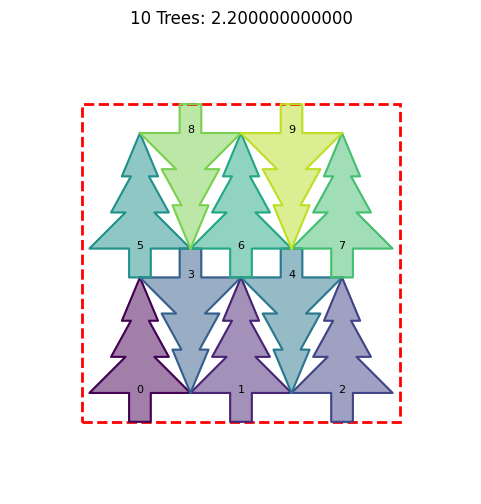

Packed 11 trees. Side: 2.4500. Time: 0.01s
Packed 12 trees. Side: 2.4500. Time: 0.02s
Packed 13 trees. Side: 2.8000. Time: 0.02s
Packed 14 trees. Side: 2.8000. Time: 0.02s
Packed 15 trees. Side: 3.0000. Time: 0.02s
Packed 16 trees. Side: 3.0000. Time: 0.03s
Packed 17 trees. Side: 3.0000. Time: 0.03s
Packed 18 trees. Side: 3.0000. Time: 0.03s
Packed 19 trees. Side: 3.1500. Time: 0.04s
Packed 20 trees. Side: 3.1500. Time: 0.04s


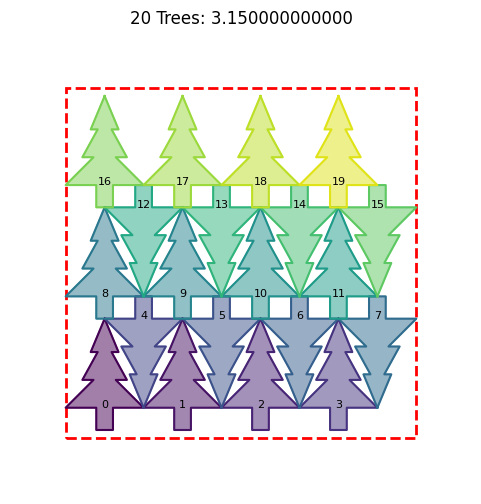

Packed 21 trees. Side: 3.2000. Time: 0.05s
Packed 22 trees. Side: 3.2000. Time: 0.05s
Packed 23 trees. Side: 3.2000. Time: 0.06s
Packed 24 trees. Side: 3.2000. Time: 0.06s
Packed 25 trees. Side: 3.5000. Time: 0.07s
Packed 26 trees. Side: 3.5000. Time: 0.07s
Packed 27 trees. Side: 3.5000. Time: 0.08s
Packed 28 trees. Side: 3.8500. Time: 0.08s
Packed 29 trees. Side: 3.8500. Time: 0.09s
Packed 30 trees. Side: 3.8500. Time: 0.10s


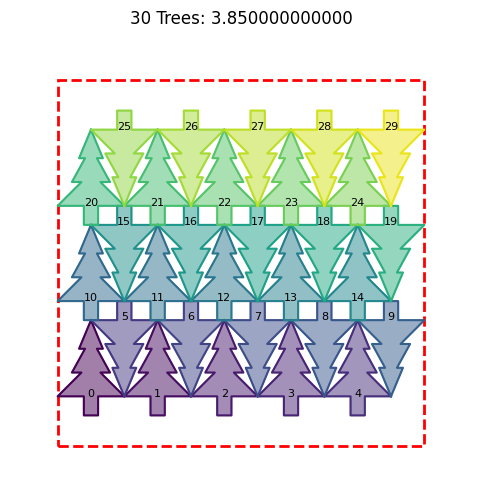

Packed 31 trees. Side: 4.0000. Time: 0.10s
Packed 32 trees. Side: 4.0000. Time: 0.11s
Packed 33 trees. Side: 4.0000. Time: 0.12s
Packed 34 trees. Side: 4.0000. Time: 0.12s
Packed 35 trees. Side: 4.0000. Time: 0.13s
Packed 36 trees. Side: 4.2000. Time: 0.14s
Packed 37 trees. Side: 4.2000. Time: 0.14s
Packed 38 trees. Side: 4.2000. Time: 0.15s
Packed 39 trees. Side: 4.2000. Time: 0.16s
Packed 40 trees. Side: 4.2000. Time: 0.17s


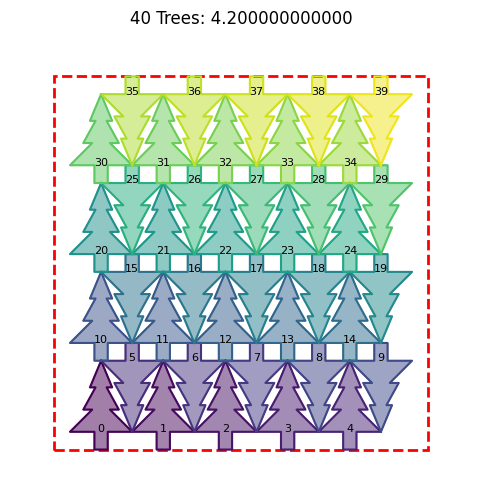

Packed 41 trees. Side: 4.2000. Time: 0.18s
Packed 42 trees. Side: 4.2000. Time: 0.19s
Packed 43 trees. Side: 4.2000. Time: 0.19s
Packed 44 trees. Side: 4.2000. Time: 0.20s
Packed 45 trees. Side: 4.5500. Time: 0.21s
Packed 46 trees. Side: 4.5500. Time: 0.22s
Packed 47 trees. Side: 4.5500. Time: 0.23s
Packed 48 trees. Side: 4.5500. Time: 0.24s
Packed 49 trees. Side: 4.9000. Time: 0.25s
Packed 50 trees. Side: 4.9000. Time: 0.27s


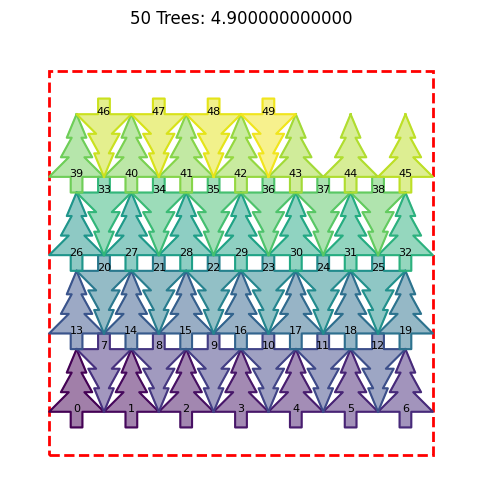

Packed 51 trees. Side: 4.9000. Time: 0.28s
Packed 52 trees. Side: 4.9000. Time: 0.29s
Packed 53 trees. Side: 5.0000. Time: 0.30s
Packed 54 trees. Side: 5.0000. Time: 0.31s
Packed 55 trees. Side: 5.0000. Time: 0.32s
Packed 56 trees. Side: 5.0000. Time: 0.33s
Packed 57 trees. Side: 5.0000. Time: 0.35s
Packed 58 trees. Side: 5.0000. Time: 0.36s
Packed 59 trees. Side: 5.0000. Time: 0.37s
Packed 60 trees. Side: 5.2000. Time: 0.38s


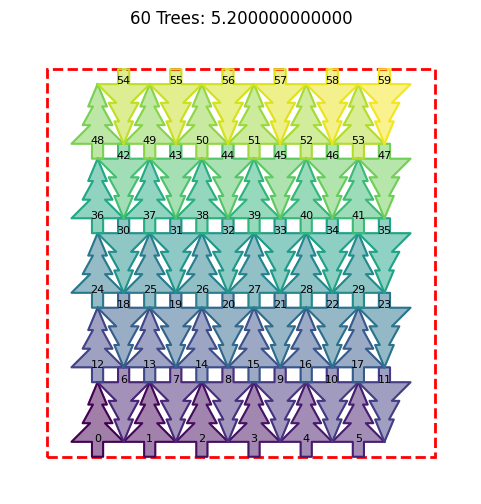

Packed 61 trees. Side: 5.2000. Time: 0.42s
Packed 62 trees. Side: 5.2000. Time: 0.41s
Packed 63 trees. Side: 5.2000. Time: 0.42s
Packed 64 trees. Side: 5.2000. Time: 0.47s
Packed 65 trees. Side: 5.2000. Time: 0.45s
Packed 66 trees. Side: 5.2500. Time: 0.46s
Packed 67 trees. Side: 5.2500. Time: 0.48s
Packed 68 trees. Side: 5.2500. Time: 0.49s
Packed 69 trees. Side: 5.2500. Time: 0.51s
Packed 70 trees. Side: 5.2500. Time: 0.52s


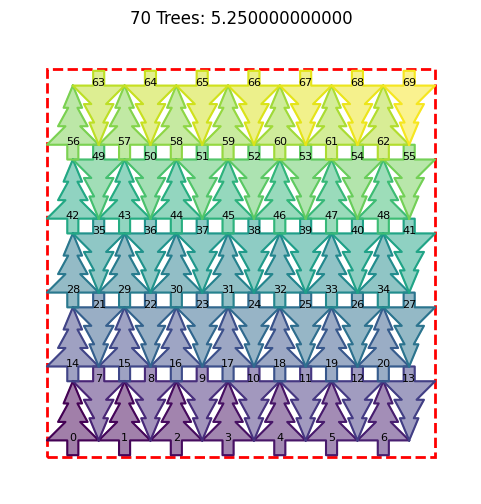

Packed 71 trees. Side: 5.6000. Time: 0.54s
Packed 72 trees. Side: 5.6000. Time: 0.55s
Packed 73 trees. Side: 5.6000. Time: 0.58s
Packed 74 trees. Side: 5.6000. Time: 0.58s
Packed 75 trees. Side: 5.6000. Time: 0.60s
Packed 76 trees. Side: 5.9500. Time: 0.61s
Packed 77 trees. Side: 5.9500. Time: 0.63s
Packed 78 trees. Side: 5.9500. Time: 0.65s
Packed 79 trees. Side: 5.9500. Time: 0.66s
Packed 80 trees. Side: 5.9500. Time: 0.68s


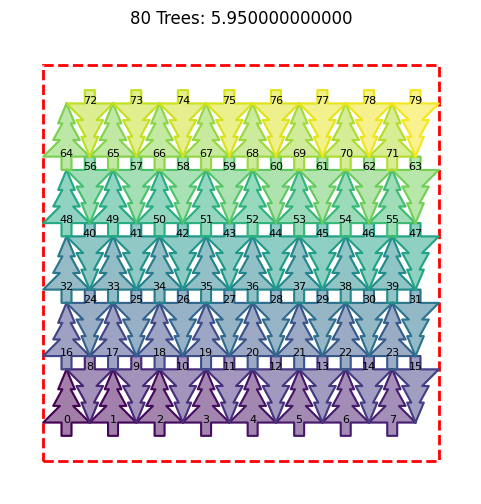

Packed 81 trees. Side: 6.0000. Time: 0.70s
Packed 82 trees. Side: 6.0000. Time: 0.72s
Packed 83 trees. Side: 6.0000. Time: 0.73s
Packed 84 trees. Side: 6.0000. Time: 0.75s
Packed 85 trees. Side: 6.0000. Time: 0.85s
Packed 86 trees. Side: 6.0000. Time: 0.80s
Packed 87 trees. Side: 6.0000. Time: 0.81s
Packed 88 trees. Side: 6.0000. Time: 0.86s
Packed 89 trees. Side: 6.2000. Time: 0.88s
Packed 90 trees. Side: 6.2000. Time: 0.96s


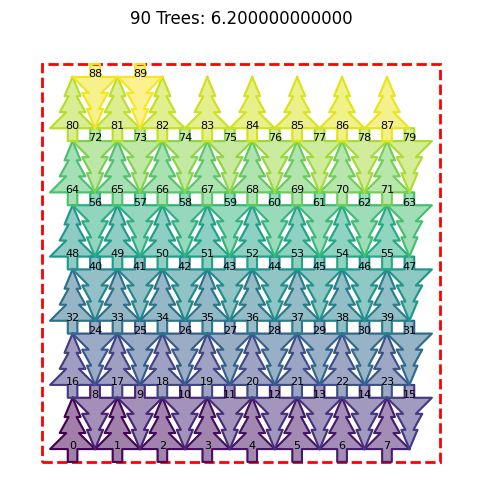

Packed 91 trees. Side: 6.2000. Time: 0.94s
Packed 92 trees. Side: 6.2000. Time: 1.03s
Packed 93 trees. Side: 6.2000. Time: 1.01s
Packed 94 trees. Side: 6.2000. Time: 0.95s
Packed 95 trees. Side: 6.2000. Time: 1.16s
Packed 96 trees. Side: 6.2000. Time: 0.98s
Packed 97 trees. Side: 6.3000. Time: 1.01s
Packed 98 trees. Side: 6.3000. Time: 1.06s
Packed 99 trees. Side: 6.3000. Time: 1.05s
Packed 100 trees. Side: 6.3000. Time: 1.08s


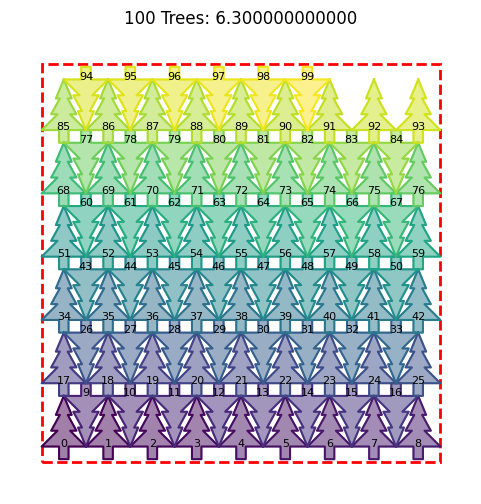

Packed 101 trees. Side: 6.3000. Time: 1.12s
Packed 102 trees. Side: 6.3000. Time: 1.16s
Packed 103 trees. Side: 6.6500. Time: 1.13s
Packed 104 trees. Side: 6.6500. Time: 1.17s
Packed 105 trees. Side: 6.6500. Time: 1.19s
Packed 106 trees. Side: 6.6500. Time: 1.19s
Packed 107 trees. Side: 6.6500. Time: 1.22s
Packed 108 trees. Side: 6.6500. Time: 1.28s
Packed 109 trees. Side: 7.0000. Time: 1.26s
Packed 110 trees. Side: 7.0000. Time: 1.33s


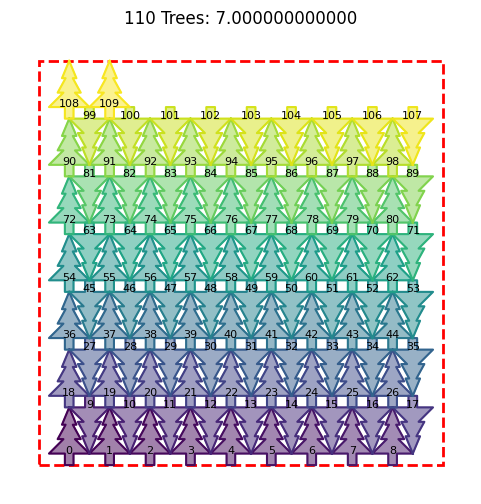

Packed 111 trees. Side: 7.0000. Time: 1.32s
Packed 112 trees. Side: 7.0000. Time: 1.44s
Packed 113 trees. Side: 7.0000. Time: 1.35s
Packed 114 trees. Side: 7.0000. Time: 1.43s
Packed 115 trees. Side: 7.0000. Time: 1.41s
Packed 116 trees. Side: 7.0000. Time: 1.48s
Packed 117 trees. Side: 7.0000. Time: 1.45s
Packed 118 trees. Side: 7.0000. Time: 1.50s
Packed 119 trees. Side: 7.0000. Time: 1.55s
Packed 120 trees. Side: 7.0000. Time: 1.56s


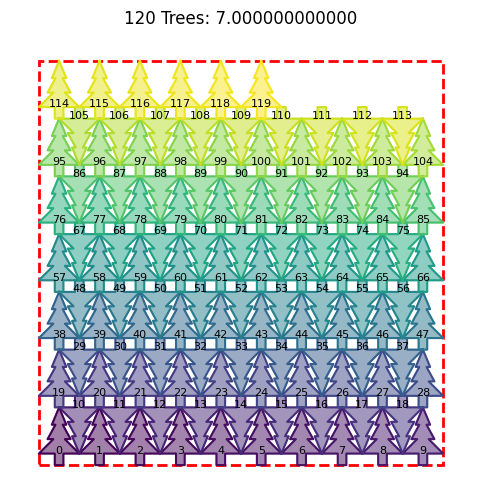

Packed 121 trees. Side: 7.0000. Time: 1.59s
Packed 122 trees. Side: 7.0000. Time: 1.59s
Packed 123 trees. Side: 7.0000. Time: 1.60s
Packed 124 trees. Side: 7.0000. Time: 1.65s
Packed 125 trees. Side: 7.2000. Time: 1.68s
Packed 126 trees. Side: 7.2000. Time: 1.68s
Packed 127 trees. Side: 7.2000. Time: 1.71s
Packed 128 trees. Side: 7.2000. Time: 1.74s
Packed 129 trees. Side: 7.2000. Time: 1.81s
Packed 130 trees. Side: 7.2000. Time: 1.81s


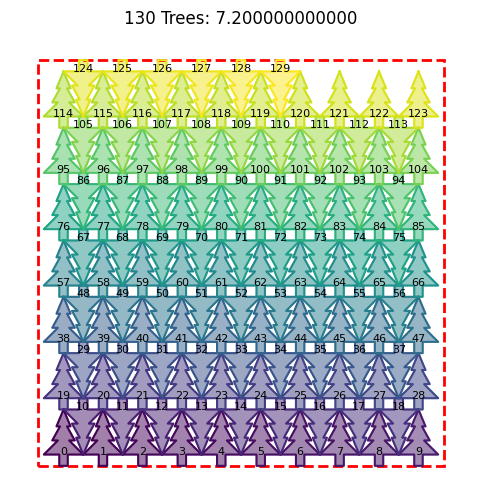

Packed 131 trees. Side: 7.2000. Time: 1.94s
Packed 132 trees. Side: 7.2000. Time: 1.89s
Packed 133 trees. Side: 7.2000. Time: 1.94s
Packed 134 trees. Side: 7.3500. Time: 1.98s
Packed 135 trees. Side: 7.3500. Time: 2.03s
Packed 136 trees. Side: 7.3500. Time: 2.02s
Packed 137 trees. Side: 7.3500. Time: 2.06s
Packed 138 trees. Side: 7.3500. Time: 2.36s
Packed 139 trees. Side: 7.3500. Time: 2.31s
Packed 140 trees. Side: 7.3500. Time: 2.11s


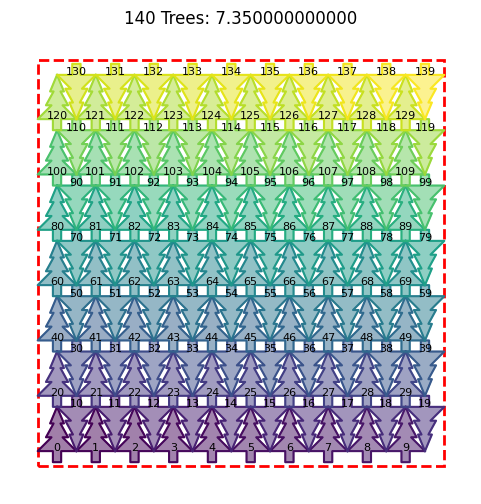

Packed 141 trees. Side: 7.7000. Time: 2.19s
Packed 142 trees. Side: 7.7000. Time: 2.22s
Packed 143 trees. Side: 7.7000. Time: 2.17s
Packed 144 trees. Side: 7.7000. Time: 2.24s
Packed 145 trees. Side: 7.7000. Time: 2.25s
Packed 146 trees. Side: 7.7000. Time: 2.27s
Packed 147 trees. Side: 7.7000. Time: 2.33s
Packed 148 trees. Side: 8.0000. Time: 2.40s
Packed 149 trees. Side: 8.0000. Time: 2.42s
Packed 150 trees. Side: 8.0000. Time: 2.45s


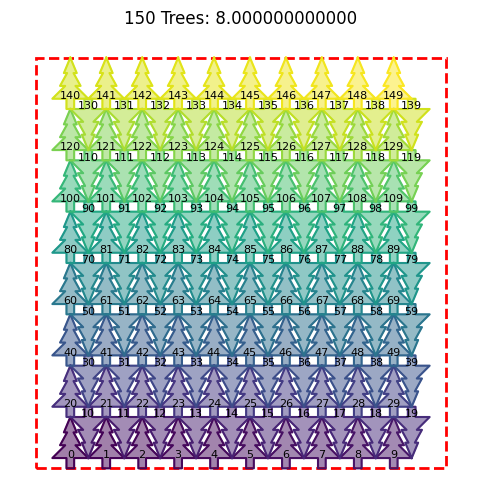

Packed 151 trees. Side: 8.0000. Time: 2.85s
Packed 152 trees. Side: 8.0000. Time: 2.49s
Packed 153 trees. Side: 8.0000. Time: 2.51s
Packed 154 trees. Side: 8.0000. Time: 2.56s
Packed 155 trees. Side: 8.0000. Time: 2.65s
Packed 156 trees. Side: 8.0000. Time: 2.66s
Packed 157 trees. Side: 8.0000. Time: 2.62s
Packed 158 trees. Side: 8.0000. Time: 2.73s
Packed 159 trees. Side: 8.0500. Time: 2.86s
Packed 160 trees. Side: 8.0500. Time: 2.77s


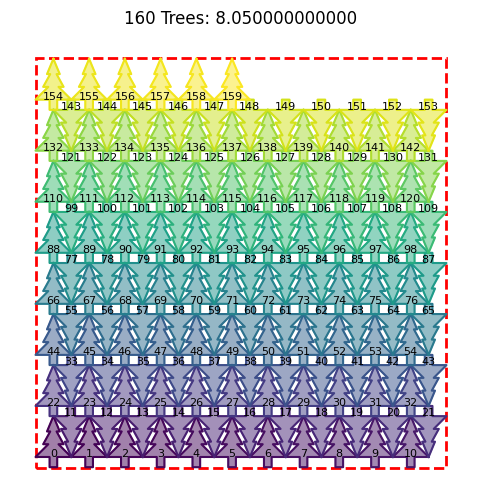

Packed 161 trees. Side: 8.0500. Time: 2.76s
Packed 162 trees. Side: 8.0500. Time: 2.79s
Packed 163 trees. Side: 8.0500. Time: 2.90s
Packed 164 trees. Side: 8.0500. Time: 2.85s
Packed 165 trees. Side: 8.0500. Time: 2.91s
Packed 166 trees. Side: 8.2000. Time: 3.01s


KeyboardInterrupt: 

In [19]:
tree_data = []
current_placed_trees = []  # Initialize an empty list for the first iteration

for n in range(200):
    start_time = time.time()
    
    # Pass the current_placed_trees to initialize_trees
    current_placed_trees, side = initialize_trees(n+1) # initialize_trees(n+1, existing_trees=current_placed_trees)

    # Run a few passes with decreasing step sizes for precision
    #compress_layout(current_placed_trees, iterations=200, step_size=0.5)
    #compress_layout(current_placed_trees, iterations=200, step_size=0.1)

    #current_placed_trees = center_all_trees(current_placed_trees)

    all_polygons = [t.polygon for t in current_placed_trees]
    bounds = unary_union(all_polygons).bounds
    width = (Decimal(bounds[2]) - Decimal(bounds[0])) / scale_factor
    height = (Decimal(bounds[3]) - Decimal(bounds[1])) / scale_factor
    side = max(width, height)
    
    print(f"Packed {n+1} trees. Side: {side:.4f}. Time: {time.time()-start_time:.2f}s")
    
    if (n+1) % 10 == 0:
        plot_results(side, current_placed_trees, n+1)
    for tree in current_placed_trees:
        tree_data.append([tree.center_x, tree.center_y, tree.angle, n+1, tree.placement_id])
        
cols = ['x', 'y', 'deg', 'n_config', 'placement_id']
submission = pd.DataFrame(
    index=index, columns=cols, data=tree_data).rename_axis('id')

for col in cols:
    submission[col] = submission[col].astype(float).round(decimals=6)
    
# To ensure everything is kept as a string, prepend an 's'
for col in submission.columns:
    submission[col] = 's' + submission[col].astype('string')
submission.to_csv('sample_submission.csv')